# JAX-MORPH Cookbook

Single time steps in simulations of biological systems - and multi-physics models in general - are usually composed of multiple sub-steps, each of which may be a complex simulation in its own right. This library provides a set of composable functions and, in general, a minimal scaffolding that can be used to to facilitate the development of such models in a modular and interoperable way. Being based on JAX, it also allows for automatic differentiation and hardware acceleration in a very natural way.

This library is essentially a wrapper around the [Equinox](https://docs.kidger.site/equinox) and [JAX-MD](https://jax-md.readthedocs.io/en/main/) libraries, to implement easily extensible spatial simulations. The idea is to have a syntax for model definition that is common to many neural network libraries like [Keras](https://keras.io/), [PyTorch](https://pytorch.org/) and [Equinox](https://docs.kidger.site/equinox) itself.

There are two main differences in terms of requirements with respect to a neural network library:
- The input state is usually more complex than a single array - multiple subfields representing different quantities associated with system components are common
- Each sub-step of the simulation may act only on a subset of the state fields
- When differentiating the simulation for optimization purposes, we might want to differentiate with respect to some quantities in some cases and others in other cases

Using the very basic and general structure provided by the base library, we implement and provide a few simulation modules tht we emply in the simulations for the associated paper. The library is designed to be easily extensible and to allow for the easy and quick development of additional custom modules.

# Imports & Utils

In [29]:
import jax
import jax.numpy as np
jax.config.update("jax_enable_x64", True)

key = jax.random.PRNGKey(0)

import jax_morph as jxm
import equinox as eqx
import jax_md


import matplotlib.pyplot as plt

In [293]:
### Animation functions

from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def animate_traj_ctype(trajectory, xlim=(-25, 25), ylim=(-25, 25)):

    sim_steps = trajectory.position.shape[0]

    def animate(i):

        state = jxm.BaseCellState(None,
                                  None,
                                  trajectory.position[i],
                                  trajectory.celltype[i],
                                  trajectory.radius[i])

        jxm.visualization.draw_circles_ctype(state)

    fig, ax = plt.subplots()
    ax.set_aspect('equal', 'box')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks([])
    ax.set_yticks([])

    anim = FuncAnimation(fig, animate, frames=sim_steps, interval=100)

    html_anim = HTML(anim.to_jshtml())

    plt.close()

    return html_anim

# Basic simulation



## State definition

First of all we have to define a data structure that represents the state of the system. Jax-morph provides `BaseCellState`, a basic structure for a state with a minimal set of attributes and functionalities. The user can extend this structure to include additional fields as needed. State fields should always have the number 

The basic state attributes are:
- `positions`: an (N,space_dim) JAX array with the positions of the particles in the system
- `celltype`: an (N,n_cell_types) JAX array that contains the probability of each particle to belong to each cell type. In the simplest case, this is a one-hot encoding of the cell type. Cells whose probabilities sum to zero are considered to be not existent and are filtered out of the simulation.
- `radius`: an (N,) JAX array with the radius of each particle

- `displacement`: a function that calculates the displacement between two positions, taking into account periodic boundary conditions if needed. See `jax_md.space` for more information.
- `shift`: a function that shifts the positions of the particles by a given displacement, taking into account boundary conditions if needed. See `jax_md.space` for more information.

Create an empty system state with 5 types of particles in 2D space. Note that since the system is empty we don't need to provide the number of particles. The space functions get initialized automatically to a euclidean space with no boundary conditions.

**NOTE:** Cells are always considered to be on axis 0 of any state field. This means that the first dimension of any field is always the number of cells, and the other dimensions depend on the specific field. This also applies to fields that in principle only necessitate of a single value per cell, like the radius.

In [30]:
istate = jxm.BaseCellState.empty(n_dim=2, n_cell_types=5)

print(istate)

BaseCellState(
  displacement=<function displacement_fn>,
  shift=<function shift_fn>,
  position=f32[0,2],
  celltype=f32[0,5],
  radius=f32[0,1]
)


We can also directly create a state initialized with appropriate field values. For the sake of this simple example, we will create a state with 10 particles in a 2D space with no boundary conditions.

In [241]:
N_CELLS = 10

#no boundary conditions (free space)
displacement_fn, shift_fn = jax_md.space.free()


key, pos_subkey, rad_subkey = jax.random.split(key, 3)

#random initial positions
pos = jax.random.uniform(pos_subkey, (N_CELLS, 2), minval=-5.0, maxval=5.0)

#all cells are of type 1
ctype = np.ones(N_CELLS)[:,None]

#random radii (check that they are positive)
rad = jax.nn.relu(jax.random.normal(shape=(N_CELLS, 1), key=rad_subkey)*.1 + .3)

istate = jxm.BaseCellState(displacement=displacement_fn, shift=shift_fn, position=pos, celltype=ctype, radius=rad)

print(istate)

BaseCellState(
  displacement=<function displacement_fn>,
  shift=<function shift_fn>,
  position=f64[10,2],
  celltype=f64[10,1],
  radius=f64[10,1]
)


We can also visualize the cells in space:

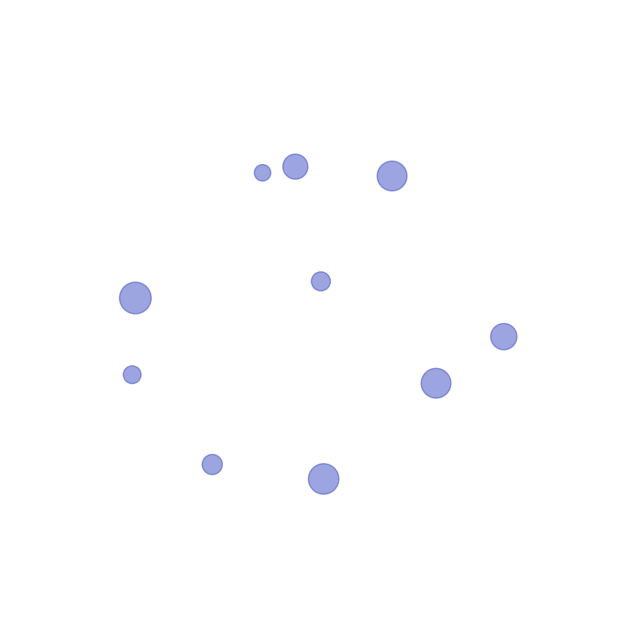

In [242]:
jxm.visualization.draw_circles_ctype(istate);

## Model definition

The model is defined as a list of functions that act on the state in sequence. Each function is considered a sub-step of the simulation, a single call to the model should in general be considred a single time step of the simulation.

To start, we can use some of the functions provided by the library. For example, we will now build a simple (useless) simulation where cells move in a 2D space with brownian motion and grow in the meantime. Cells interact with a [Morse potential](https://en.wikipedia.org/wiki/Morse_potential) so that they cannot interpenetrate each other too much but they tend to stay close to each other when they meet.

In [264]:
#cells interact with morse potential
#minimum of the potential is automatically set to touching distance between cells
mech_potential = jxm.env.mechanics.MorsePotential(epsilon=3., alpha=3., r_cutoff=20., r_onset=15.)


model = jxm.Sequential([

    #cell radius grows linearly in time
    jxm.env.CellGrowth(growth_rate=.005, max_radius=2., growth_type='linear'),

    #cells move with brownian dynamics for 100 steps after each growth step
    jxm.env.mechanics.BrownianMechanicalRelaxation(mech_potential, relaxation_steps=10, kT=1., dt=1e-4)
])

## Running&Visualizing the model

We can run one step of the model by simply calling the model on the state object. We can also run multiple steps by calling the model multiple times in a loop.

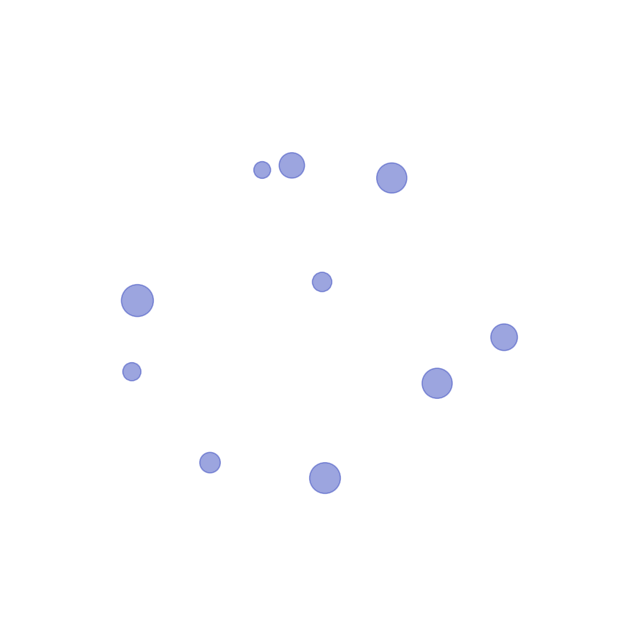

In [289]:
key, subkey = jax.random.split(key)

#advance dynamics by one step
new_state = model(istate, key=subkey)

jxm.visualization.draw_circles_ctype(new_state);

We can run multiple steps of the model by calling the model multiple times in a loop. We can also visualize the state at each step to see how the simulation evolves.

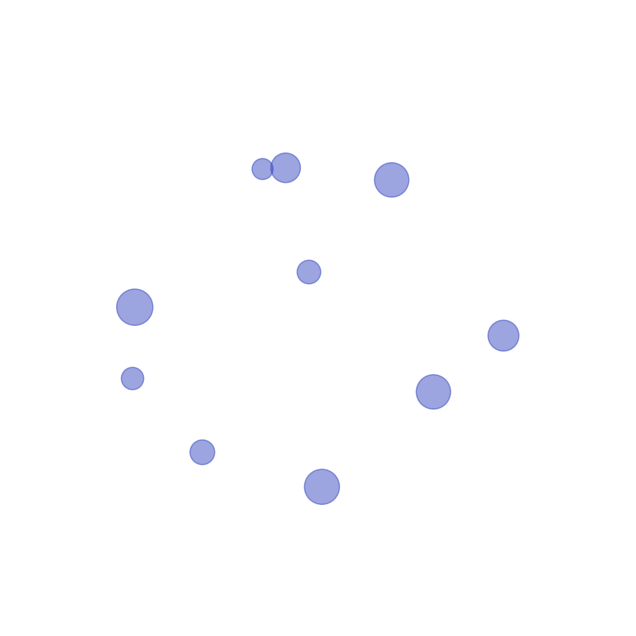

In [290]:
fstate = model(istate, key=subkey)

for i in range(10):
    key, subkey = jax.random.split(key)
    fstate = model(fstate, key=subkey)


jxm.visualization.draw_circles_ctype(fstate);

Instead of doing this by hand, we can use `jxm.simulate` to run the simulation. The function uses the much faster `jax.lax.scan` function to loop over simulation steps and handle the random keys automatically. We can also have `jxm.simulate` return the whole state trajectory, which can be useful for further analysis.

In [291]:
SIM_STEPS = 10

key, run_key = jax.random.split(key)

trajectory = jxm.simulate(model, istate, key=run_key, n_steps=SIM_STEPS, history=True)

print(trajectory)

BaseCellState(
  displacement=<function displacement_fn>,
  shift=<function shift_fn>,
  position=f64[10,10,2],
  celltype=f64[10,10,1],
  radius=f64[10,10,1]
)


We can draw any of the intermediate states (in this case the final state):

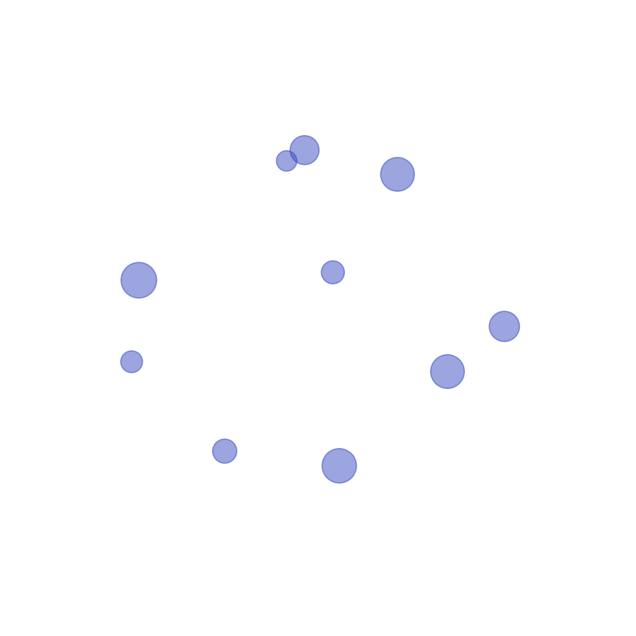

In [292]:
fstate = jxm.BaseCellState(trajectory.displacement,
                           trajectory.shift,
                           trajectory.position[-1],
                           trajectory.celltype[-1],
                           trajectory.radius[-1])


jxm.visualization.draw_circles_ctype(fstate);

We can also visualize the time evolution of the system:

In [287]:
animate_traj_ctype(trajectory)

# More complex simulations

We can use the same structure and embedded functions to build more complex simulations, where cells have additional attributes and interact with each other in more complex ways. We can also introduce cell division, which presents some additional subtleties due to the inner workings of JAX.

## Chemical signaling

We want cells to be able to communicate with each other through a chemical signal. In order to do this, we need to extend the state to include a field for the concentration of the chemical, implement diffusion of the chemical in space and add a mechanism for cells to adjust chemical production.

To simulate approximate steady state diffusion with removal at cell position, we will use `jxm.env.ApproxSteadyStateDiffusion` which requires the system state to have a `chemical` field. 

In [294]:
# all of the attributes of BaseCellState, plus the chemical field
class MyCellState(jxm.BaseCellState):
    chemical:   np.ndarray

In [ ]:
my_istate = MyCellState(displacement=displacement_fn, 
                        shift=shift_fn, 
                        position=pos, 
                        celltype=ctype, 
                        radius=rad,
            )